In [37]:
## Importing dependencies-------------------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import warnings
import os
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
os.chdir('/home/stefan/jupyter-lab-projects/CLL/bee-project/honey_bee_behavior/') ##New user? Change me!
PATH = '/home/stefan/jupyter-lab-projects/CLL/bee-project/honey_bee_behavior/' ##Me too!
DATAPATH = '/home/stefan/jupyter-lab-projects/CLL/bee-data/'


#DELETED FREQ PARAMETER FROM DEFINITIONS_2018
from bees_lifetimetracking_2018data import datafunctions
from bees_lifetimetracking_2018data import definitions_2018 as bd
from bees_lifetimetracking_2018data import displayfunctions as bp
import definitions2024 as bn

datafunctions.init(bd) 
bp.init(bd)
warnings.filterwarnings("ignore")


# Establishing date range and basic dataset information----------------------------------------------------
year = 2018
startday = pd.Timestamp(year,7,16)  # actual, for 2018:   16 July  (cameras turned on)
endday = pd.Timestamp(year,10,9)    # actual, for 2018:   was 10 September, but is now 09 Oct
alldaytimestamps = pd.date_range(start=startday,end=endday,freq='D')
numdays = len(alldaytimestamps)
numbees = 4096  # This is the total number of barcodes, NOT the total number of bees actually tracked
numsubstrates = 10 # 10 actual substrates, and then 0 for undefined
comb_daynums = np.array([ 0,  5, 10, 15, 20, 26, 30, 35, 40, 44, 65, 75, 85]) + 16 - startday.day  # days from start day, assuming start day is in July

# get bee cohort data, and just process these for a single one
cohort_data = pd.read_csv(PATH + 'bees_lifetimetracking_2018data/all_cohorts.csv')

cohort_colornames = np.unique(cohort_data['cohort'])
cohort_tagids = [np.array(cohort_data[cohort_data['cohort']==name]['beeID']) for name in cohort_colornames]
cohort_birthdates = np.array([pd.Timestamp(np.array(cohort_data['DOB'][cohort_data['cohort']==c])[0]) for c in cohort_colornames])
pix = bd.xpixels #for methods in definitions2024

def rawLeaveEvents(daynum, beeTraj, hiveEvents):
    dfIntersect = pd.merge(hiveEvents, beeTraj, how='inner', on = ['uid','framenum'])
    #exit_dist------------------------------------------------------------------------------------
    dfIntersect = getExitDist(dfIntersect)
    dfIntersect = bn.numOfDanceFloorVisitsRUNNINGTOTAL(dfIntersect)
    
    return dfIntersect[dfIntersect['status']=='leave']

def loadData(daynum):
    global day_uids, day_ages, boolInHiveByIDByTime, bee_obs, bee_exitdist, numtimedivs
    ### DID THE BEE LEAVE? ------------------------------------------------------------------
    dataDir = DATAPATH + 'df_day1min_alldays/' # changed PATH to DATAPATH
    dfday = pd.read_hdf('{}df_day1min_{:0>2}.hdf'.format(dataDir,daynum))
    numtimedivs = len(dfday['timedivision'].unique()) # minutes in a day
    day_uids, day_ages, boolInHiveByIDByTime, bee_obs, bee_exitdist = datafunctions.get_inout_estimates(dfday, numtimedivs=numtimedivs)

## Adds column of distances from the exit
def getExitDist(df):
    df['exit_dist'] = datafunctions.getexitdistance(df.x,df.y,df.camera)
    return df

## Creates dataframe based on given day and adds available information.
def getBeeTraj(daynum):
    if daynum >= 50:
        datadir = DATAPATH + 'beetrajectories_days_050_to_085/' #changed
    else:
        datadir = DATAPATH + 'beetrajectories_days_000_to_049/' #changed
    
    beeTrajectoriesByFrame = pd.read_hdf('{}beetrajectories_{:0>3}.hdf'.format(datadir,daynum)) #data per frame in which each bee was seen
    beeTrajectoriesByFrame = getExitDist(beeTrajectoriesByFrame)
    beeTrajectoriesByFrame= bn.crossedDanceFloor(beeTrajectoriesByFrame, pix)
    return beeTrajectoriesByFrame

def getHiveEvents(daynum):
    # boolInHiveByIDByTime into dataframe ----------------------------------------------------
    inHive = pd.DataFrame(boolInHiveByIDByTime)
    inHive = inHive.T #transpose so rows = time and cols = uid
                                
    #get hive statuses by taking difference on axis 0 (rows, which represent time)
    hive_statuses_list = np.diff(inHive, axis = 0) # TODO document code
    #print(len(hive_statuses_list[1])) #PRINT CHECK (len 1439, len of each is 1435)
    
    # translate time to framenum (assuming 3 frames per second)-------------------------------
    frames_per_day = 24*60*60*3
    frames_per_timedivision = frames_per_day / numtimedivs
    
    """
    inHive['index'] = range(len(inHive))
    inHive['minsPastMidnight'] = inHive['index']*1 #bin size = 1min (see datafunctions.py), TODO un-hardcode
    
    
    inHive['framenum'] = inHive['index']*frames_per_timedivision
    """
    
    hive_statuses_by_uid = []
    
    #return [i for i in zip(day_uids,hive_statuses_list)]
    
    hive_statuses_list = np.transpose(hive_statuses_list) # First index is beeUID, second is minute
    for uid, hive_statuses in zip(day_uids,hive_statuses_list):
        for hive_status in hive_statuses:
            hive_statuses_by_uid.append([uid,hive_status])
    df_hive_events = pd.DataFrame(hive_statuses_by_uid,columns=['uid','diff'])
    df_hive_events['index'] = range(len(df_hive_events))
    
    #minutes and framenum columns---------------------------------------------------------------
    result = []
    numEntriesPerUid = len(df_hive_events[df_hive_events['uid'] == df_hive_events['uid'].iat[0]])
    for value in df_hive_events['index']:
        result.append(value % numEntriesPerUid)
    df_hive_events['min'] = result
    
    df_hive_events['framenum'] = df_hive_events['min']*frames_per_day/(24*60)
    
    df_hive_events = df_hive_events[['index', 'uid', 'diff', 'min', 'framenum']]
    
    #stauses--------------------------------------------------------------------------------------
    conditions = [
        (df_hive_events['diff'] == -1.0),
        (df_hive_events['diff'] == 1.0),
        (df_hive_events['diff'] == 0.0),
    ]
    choices = ['leave', 'return', 'no change']
    df_hive_events['status'] = np.select(conditions, choices, default='not sure')
    
    """
    for plotting purposes, single out rows in beetraj df and surrounding rows to track data.
    
    add function to do exit distance and num dance floor visits for selected rows (new df)
    """
    
    return df_hive_events

#defines frameNew, frameReturn, frameGone, and returns leaveEvents dataFrame
def getLeaveEvents(daynum, beeTraj, hiveEvents):
    rawEvents = pd.DataFrame()
    rawEvents = rawLeaveEvents(daynum, beeTraj, hiveEvents)
    filteredEvents = pd.DataFrame()
    filteredEvents, frameNew, frameReturn, frameGone = getPlottingEvent(daynum, df, frame, beeID, framesBefore, framesAfter)
    
    filteredEvents = rawEvents.drop(columns=['index', 'diff', 'status'])
    return filteredEvents
# Modify to check location before leaving and time gone.

def plotEvent(daynum, frame, beeID, framesBefore, framesAfter):
    # getting desired rows
    plotPoint = pd.DataFrame()
    plotPoint, frameNew, frameReturn, frameGone = bn.getPlottingEvent(daynum, beeTraj, frame, beeID, framesBefore, framesAfter)
 
    # create figure x = framenum, y = y, color gradient = x
    plt.figure(figsize=(10, 6))
    
    #""" EXIT DISTANCE VS FRAMENUM
    plt.scatter(plotPoint['framenum'], plotPoint['exit_dist'], s=10, alpha=0.8, label='Data')

    #labels
    plt.xlabel('Frame Number')
    plt.ylabel('Exit Distance')
    plt.title('Plot of Exit Distance vs. Frame Number')
    #"""
    
    """ Y VS FRAMENUM, X VARIATION
    plt.scatter(plotPoint['framenum'], plotPoint['y'], c=plotPoint['x'], cmap='viridis', s=10, alpha=0.8, label='Data') 
    
    # if you'd like the graph to start at y = 0
    #plt.ylim([0, plotPoint['y'].max()+0.5])

    #gradient to represent x:
    cbar = plt.colorbar()
    cbar.set_label('X-Coordinate')

    #labels
    plt.xlabel('Frame Number')
    plt.ylabel('Y Coordinate')
    plt.title('Plot of Y-Coordinate vs. Frame Number with X-Coordinate Variation')
    """

    # red dashed line to indicate where the 'leave' event is
    plt.axvline(x=frameNew, color='lawngreen', linestyle='-', label='Leave')
    
    #new black line to indicate bee disappearance
    if(frameGone <= plotPoint['framenum'].max() + 20):
        plt.axvline(x=frameGone, color='black', linestyle='-', label='disappearance')
    if(frameReturn <= plotPoint['framenum'].max() + 20):
        if(frameReturn != -1):
            plt.axvline(x=frameReturn, color='red', linestyle='-', label='Return')
    """         
    print(frameNew)
    print(framesBefore)
    for frame in range(frameNew - framesBefore, frameNew+framesAfter): 
        if frame % 180 ==0: #180 frames = 1 minute
            plt.axvline(x=frame, color='grey', linestyle='-')
    """

    #Add grid and legend, then show plot
    plt.gca().yaxis.grid(True)
    plt.legend(loc = 'lower center')
    plt.show()
#date time package in python to keep track of frames/days/minutes - see prelim analysis 2024 comb building
# better documentation please T-T

## Start here!!

In [38]:
#STEP 1: Enter day number
daynum = 20

#loading...--------------------
loadData(daynum)

beeTraj = getBeeTraj(daynum)
hiveEvents = getHiveEvents(daynum)
#------------------------------

#Prints your options of leaving events!
leave = pd.DataFrame()
leave = rawLeaveEvents(daynum, beeTraj, hiveEvents)
leave[['daynum', 'uid', 'framenum', 'exit_dist', 'running_total_df_visits']]

,daynum,uid,framenum,exit_dist,running_total_df_visits
208,20,1002,177840.0,952.773320,5
389,20,1007,26280.0,858.963329,0
410,20,1007,32220.0,910.464167,0
490,20,1011,66780.0,865.088435,0
491,20,1011,67140.0,881.442568,0
...,...,...,...,...,...
60988,20,2942,237420.0,608.615642,0
61392,20,2985,258120.0,840.348737,2
62107,20,3054,243720.0,561.081990,1
62113,20,3055,237240.0,854.578844,0


Leave:  243272
Return:  243670
Disappears:  256069


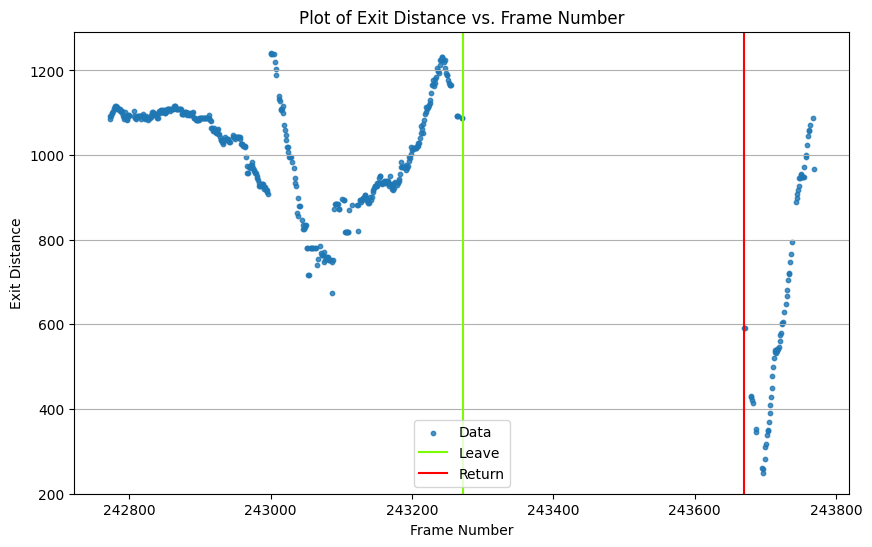

In [39]:
#STEP 2: Enter a framenumber, bee ID, number of frames before (to be plotted), and number of frames after!
frame = 243720.0
beeID = 3054

framesBefore = 500
framesAfter = 1000

#loading...----------------------
plotPoint = plotEvent(daynum, frame, beeID, framesBefore, framesAfter)
plotPoint
#--------------------------------

- interactions data from stefan
- visits to the dance floor (IN PROGRESS)
- refining leaving events
- combing exit dist problem
- thesis outline
- literature review - talk to colin? michael, see what Ethan dug up last sem., tom sealey
- bee behavior, foraging, transition to foraging with age, existing models + hypotheses
- google scholar for literature, review sources
- leave.where ( exit_dist <100)
- dig up the sources on regression modeling + stats

In [40]:
test = bn.numOfDanceFloorVisitsRUNNINGTOTAL(beeTraj)
test[['uid', 'framenum', 'cross_df', 'running_total_df_visits']]

,uid,framenum,cross_df,running_total_df_visits
0,846,30343,0,0
1,846,30344,0,0
2,846,30345,0,0
3,846,30349,0,0
4,846,30350,0,0
...,...,...,...,...
11294848,3103,247363,0,10
11294849,3103,247364,1,11
11294850,3103,247365,1,11
11294851,3103,247366,0,11


### Analysis

In [41]:
# ADDITION: Number of recent dance floor visits
leave

,index,uid,diff,min,framenum,status,daynum,x,y,camera,theta,exit_dist,cross_df,running_total_df_visits
208,5305,1002,-1.0,988,177840.0,leave,20,2375,5408,0,-0.679035,952.773320,0,5
389,8780,1007,-1.0,146,26280.0,leave,20,2823,4935,0,2.965010,858.963329,0,0
410,8813,1007,-1.0,179,32220.0,leave,20,2975,4800,0,-0.529838,910.464167,0,0
490,11883,1011,-1.0,371,66780.0,leave,20,2559,5199,0,-1.984070,865.088435,1,0
491,11885,1011,-1.0,373,67140.0,leave,20,2526,5223,0,-1.329980,881.442568,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60988,1859068,2942,-1.0,1319,237420.0,leave,20,2918,5175,0,-1.494910,608.615642,0,0
61392,1918182,2985,-1.0,1434,258120.0,leave,20,2927,4897,0,0.179644,840.348737,0,2
62107,2007320,3054,-1.0,1354,243720.0,leave,20,3078,5135,0,-1.310510,561.081990,0,1
62113,2008723,3055,-1.0,1318,237240.0,leave,20,2855,4920,0,0.366933,854.578844,0,0


In [42]:
leave[(leave['uid'] == 3054) & (leave['framenum'] > 203720.0)]

,index,uid,diff,min,framenum,status,daynum,x,y,camera,theta,exit_dist,cross_df,running_total_df_visits
62107,2007320,3054,-1.0,1354,243720.0,leave,20,3078,5135,0,-1.31051,561.08199,0,1


In [71]:
def interaction_events(beeTraj, beeID, minFrame, maxFrame, distance_thresh=10):
    """
    Returns dataFrame listing interaction events during which the bee with ID beeID is nearby another bee, within
    the time window between minTime and maxTime.  Here "nearby" means within a distance threshold and on the same 
    side of the hive.

    beeTraj                   : Trajectory dataframe containing framenumbers, (x,y) coordinates, and camera information.
    minFrame                  : Minimum framenum to scan for interaction events
    maxFrame                  : Maximum framenum to scan for interaction events
    distance_thresh (default value=10)     : Distance in pixels within which two bees must be imaged in the same frame to count as an interaction
    """
    
    # Filter for the frame window
    beeTraj_selected = beeTraj[(beeTraj['framenum'] >= minFrame) & (beeTraj['framenum'] <= maxFrame)]
    
    # Data for the selected bee
    beeTraj_selected_bee = beeTraj_selected[beeTraj_selected['uid'] == beeID]

    # List to store interaction data
    interaction_data = []

    # Loop over frames where the selected bee is present
    for frame in beeTraj_selected_bee['framenum'].unique():
        # Data for all bees in the current frame
        all_bee_frame_data = beeTraj_selected[beeTraj_selected['framenum'] == frame]

        # Data for the selected bee in the current frame
        selected_bee_frame_data = all_bee_frame_data[all_bee_frame_data['uid'] == beeID]
        beex = selected_bee_frame_data['x'].iloc[0]
        beey = selected_bee_frame_data['y'].iloc[0]
        beecamera = selected_bee_frame_data['camera'].iloc[0]

        # Filter for bees on the same side (same camera) in the current frame
        same_side_bees = all_bee_frame_data[all_bee_frame_data['camera'] == beecamera]

        # Compute distances
        distances = np.sqrt((same_side_bees['x'] - beex)**2 + (same_side_bees['y'] - beey)**2)

        # Select nearby bees within the distance threshold, excluding the beeID itself
        nearby_bees = same_side_bees[(distances <= distance_thresh) & (same_side_bees['uid'] != beeID)]
        nearby_bees['distance'] = distances[nearby_bees.index]

        # Append interaction data
        for _, row in nearby_bees.iterrows():
            interaction_data.append([
                frame,  # Frame number
                row['uid'],  # Other bee's ID
                row['x'],  # Other bee's x-coordinate
                row['y'],  # Other bee's y-coordinate
                row['camera'],  # Camera (side of hive)
                row['distance']  # Distance to selected bee
            ])

    # Convert interaction data into a DataFrame
    return pd.DataFrame(interaction_data, columns=['framenum', 'uid', 'x', 'y', 'camera', 'distance'])
    

In [68]:
beeID = 3000
minFrame = 1000
maxFrame = 500000
distance_thresh = 100

interactions_test = interaction_events(beeTraj, beeID, minFrame, maxFrame, distance_thresh)
interactions_test

,framenum,uid,x,y,camera,distance
0,204848,2774.0,1671.0,4078.0,0.0,62.817195
1,204850,2774.0,1671.0,4086.0,0.0,72.945185
2,206120,1303.0,2110.0,4032.0,0.0,91.923882
3,206121,1303.0,2110.0,4031.0,0.0,90.520716
4,206122,1303.0,2102.0,4023.0,0.0,92.005435
...,...,...,...,...,...,...
303,255818,2084.0,1439.0,1249.0,1.0,93.434469
304,255821,1238.0,1375.0,1311.0,1.0,80.808415
305,255822,1238.0,1382.0,1319.0,1.0,80.024996
306,255827,2084.0,1375.0,1374.0,1.0,90.603532


In [69]:
def plot_interactions(interactions_df):
    """
    Plots each interaction as a point on a 2D scatterplot.

    Parameter:
        interactions_df (pd.DataFrame): DataFrame of interactions with columns 'x' and 'y'.

    Returns:
        void
    """
    # Extract x and y coordinates from the dataframe
    x_coords = interactions_df['x']
    y_coords = interactions_df['y']
    
    # Create the scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(x_coords, y_coords, alpha=0.7, edgecolor='k', s=50)
    plt.title("Interactions Scatterplot", fontsize=16)
    plt.xlabel("X Coordinate", fontsize=12)
    plt.ylabel("Y Coordinate", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


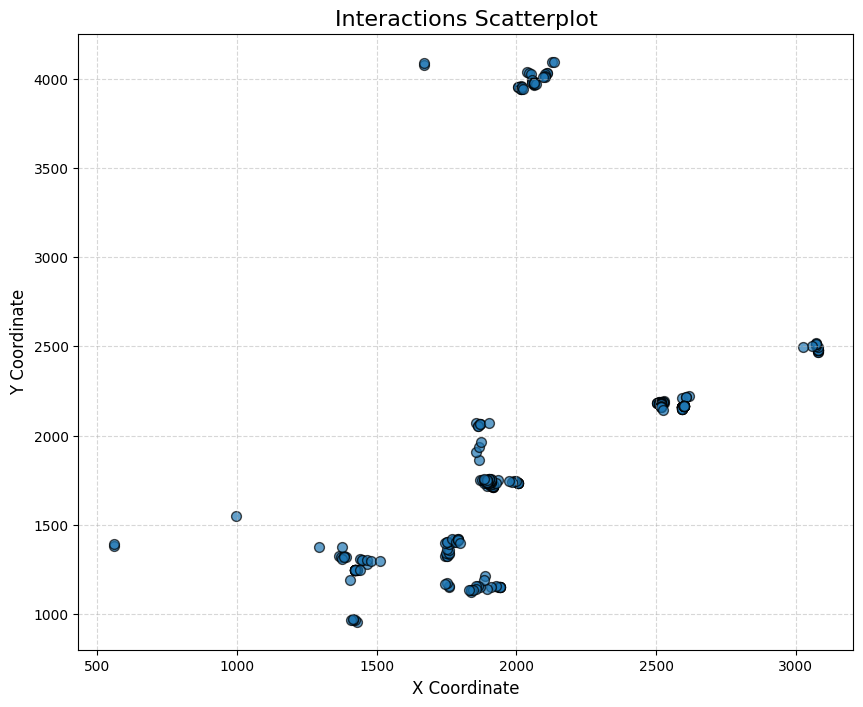

In [70]:
plot_interactions(interactions_test)

## notes from 11-22
analyze uniqueness on interactions (within 10s? 30 frames?)

add further detail to plots e.g. TSA/coloration
